In [143]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import qwikidata
import random
import matplotlib.pyplot as plt
from qwikidata.json_dump import WikidataJsonDump
from qwikidata.linked_data_interface import get_entity_dict_from_api
from qwikidata.sparql import (get_subclasses_of_item,
                              return_sparql_query_results)
from collections import Counter
import ast
from qwikidata.linked_data_interface import LdiResponseNotOk
from qwikidata.entity import WikidataItem, WikidataProperty, WikidataLexeme
import sqlite3
from urllib3.exceptions import MaxRetryError
import threading
import time
import timeit
import traceback
import plotly.graph_objects as go
import tldextract
from urllib.parse import urlparse
import ssl
import languages_and_countries
from samplesize import sampleSize
import importlib

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=1)
import pickle

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
wikidata_db = sqlite3.connect('/mnt/data/group3/wikidata/part/wikidata_apr.db')
#wikidata_db = sqlite3.connect('F:/wikidata_apr.db')

sql_cursor = wikidata_db.cursor()

def kill(conn):
    while True: 
        with open('iskill.txt','r') as f:
            time.sleep(1)
            if f.readline().strip() == 'yes':
                print('killed')
                conn.interrupt()
                break
                
th = threading.Thread(target=kill,args=[wikidata_db])
th.start()

In [194]:
update = False

color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9',   
                      '#C1F0F6', '#0099CC']
datatype_to_color_dict = {
    'wikibase-item': '#EA96A3',
    'external-id': '#53ACCD',
    'string': '#60AE47',
    'time': '#B89C49',
    'monolingualtext': '#E78CD7',
    'url': '#9BADE9',
    'quantity': '#E19153',
    'commonsMedia': '#4AAC99',
    'globe-coordinate': 'gray',
    'wikibase-property': 'gray',
    'geo-shape': 'gray',
    'math': 'gray',
    'wikibase-lexeme': 'gray',
    'wikibase-form': 'gray',
    'musical-notation': 'gray',
    'tabular-data': 'gray',
    'wikibase-sense': 'gray'
}

def datatype_to_colour(datatype):
    if datatype in datatype_to_color_dict:
        return datatype_to_color_dict[datatype]
    else:
        return 'gray'

In [152]:
try:
    with open('data/entity_cache.p','rb') as f:
        entity_cache = pickle.load(f)
except FileNotFoundError:
    entity_cache = {}

def save_entity_cache():
    global entity_cache
    with open('data/entity_cache.p','wb') as f:
        pickle.dump(entity_cache,f)

def get_entity(item_id):
    global entity_cache
    if item_id in entity_cache:
        return entity_cache[item_id]
    while True:
        try:
            entity = get_entity_dict_from_api(item_id)
            entity_cache[item_id] = entity
            save_entity_cache()
            return entity
        except ConnectionError:
            #traceback.print_exc()
            continue
        except MaxRetryError:
            #traceback.print_exc()
            time.sleep(1)
        except LdiResponseNotOk:
            #traceback.print_exc()
            entity_cache[item_id] = 'deleted'
            save_entity_cache()
            return 'deleted'

def get_label(item):
    if type(item) == str:        
        entity = get_entity(item)
        if entity == 'deleted':
            return entity
        labels = entity['labels']
    elif type(item) == dict:
        labels = item['labels']
    languages = ['en','fr','es','pt','pt-br','it','de']
    for l in languages:
        if l in labels:
            return labels[l]['value']
    return 'no-label'

def get_datatype(item):
    try:
        if type(item) == str:
            entity = get_entity(item)
            if entity == 'deleted':
                return entity
            datatype = entity['datatype']
        elif type(item) == dict:
            datatype = item['datatype']
        return datatype
    except KeyError:
        return 'none'

def get_claim_values_of(item, property_id):
    if type(item) == str:
        entity = get_entity(item)
        if entity == 'deleted':
            return entity
        claims = entity['claims']
    elif type(item) == dict:
        claims = item['claims']
    if property_id in claims:
        instance_of_claims = claims[property_id]
        return [i['mainsnak']['datavalue']['value']['id'] for i in instance_of_claims]
    else:
        return []
    
def aggregate_other(df, by, count_name='count', other_thr=1):
    df_c = df.copy()
    df_c = df_c[[by,count_name]]
    total_count = df_c[count_name].sum()
    df_c['per'] = df_c[count_name].apply(lambda x: 100*x/total_count)

    other_df_c = df_c[df_c['per'] < other_thr].sum()
    other_df_c[by] = 'other'

    df_c = df_c.append(
        other_df_c, ignore_index=True
    ).sort_values('per',ascending=False).reset_index(drop=True)
    df_c = df_c[df_c['per'] >= other_thr]

    return df_c

# Head 10 of each table

## Claims

In [5]:
sql_cursor.execute(
    ''' select * from claims limit 10 '''
)
head_10 = pd.DataFrame(sql_cursor.fetchall())
head_10.columns = ['entity_id','claim_id','claim_rank','property_id','datatype','datavalue']
head_10

,entity_id,claim_id,claim_rank,property_id,datatype,datavalue
0,Q8,Q8$475e48c8-41fa-5739-e46e-27ff20507977,normal,P1245,external-id,"{'value': '885155', 'type': 'string'}"
1,Q8,q8$0FC7FB9A-B5CA-4762-98AE-1B0BDC1EEF39,normal,P373,string,"{'value': 'Happiness', 'type': 'string'}"
2,Q8,q8$E2EFA381-BA5D-4F52-AF74-660B9A044C1E,normal,P31,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
3,Q8,q8$5DB9C22E-4D86-4FB1-AC36-5C75CC806D6A,normal,P31,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
4,Q8,Q8$320b6d85-4fc0-a244-ffa5-fa8ac6bf8727,normal,P31,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
5,Q8,q8$522798CD-60CD-4EAE-BE3B-365EFD24F2EC,normal,P508,external-id,"{'value': '13163', 'type': 'string'}"
6,Q8,q8$7dcd6734-4ece-8b37-9386-92e5d4e801cd,normal,P18,commonsMedia,"{'value': 'Sweet Baby Kisses Family Love.jpg',..."
7,Q8,Q8$E805258B-7B18-4558-980E-425F5713DF51,normal,P910,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
8,Q8,Q8$A6CF669F-6DD6-49A3-B084-6A31B119A535,normal,P349,external-id,"{'value': '00566227', 'type': 'string'}"
9,Q8,Q8$63214A9F-B2C8-42F9-8DA0-B046A989DDCF,normal,P646,external-id,"{'value': '/m/016pp7', 'type': 'string'}"


## Refs

In [6]:
sql_cursor.execute(
    ''' select * from refs limit 10 '''
)
head_10 = pd.DataFrame(sql_cursor.fetchall())
head_10.columns = ['reference_id','reference_property_id','reference_index','reference_datatype','reference_value']
head_10

,reference_id,reference_property_id,reference_index,reference_datatype,reference_value
0,a235ba3d92daf43853b23688674b7ab464b4eea8,P248,0,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
1,2b00cb481cddcac7623114367489b5c194901c4a,P248,0,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
2,2b00cb481cddcac7623114367489b5c194901c4a,P577,0,time,"{'value': {'time': '+2013-10-28T00:00:00Z', 't..."
3,b3fd5e254143d8b52cd96cff43af9af5e3a82358,P143,0,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
4,9a24f7c0208b05d6be97077d855671d1dfdbc0dd,P143,0,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
5,cf50b45136fd995bef3c409e86b9d66ae8184ff0,P248,0,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
6,cf50b45136fd995bef3c409e86b9d66ae8184ff0,P854,0,url,{'value': 'http://thes.bncf.firenze.sbn.it/ter...
7,cf50b45136fd995bef3c409e86b9d66ae8184ff0,P813,0,time,"{'value': {'time': '+2017-10-03T00:00:00Z', 't..."
8,848c7514b88b1f487526b9556ccde288c97daabd,P813,0,time,"{'value': {'time': '+2018-05-06T00:00:00Z', 't..."
9,f9bf1a1f034ddd51bd9928ac535e0f57d748e2cf,P248,0,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."


## Claims and Refs joint

In [7]:
sql_cursor.execute(
    ''' select * from claims_refs limit 10 '''
)
head_10 = pd.DataFrame(sql_cursor.fetchall())
head_10.columns = ['claim_id','reference_id']
head_10

,claim_id,reference_id
0,q8$522798CD-60CD-4EAE-BE3B-365EFD24F2EC,a235ba3d92daf43853b23688674b7ab464b4eea8
1,Q8$63214A9F-B2C8-42F9-8DA0-B046A989DDCF,2b00cb481cddcac7623114367489b5c194901c4a
2,Q8$D568DFE7-62F7-42F3-A62C-5535E2F375D3,b3fd5e254143d8b52cd96cff43af9af5e3a82358
3,Q8$056EE957-2C74-4507-9E61-861491C5271C,9a24f7c0208b05d6be97077d855671d1dfdbc0dd
4,Q8$98479cc7-4935-829b-da8d-2eb4adb80a6b,cf50b45136fd995bef3c409e86b9d66ae8184ff0
5,Q8$4c54aeba-42dc-f2cf-66db-41e65e7526ef,cf50b45136fd995bef3c409e86b9d66ae8184ff0
6,Q8$23735853-49a7-af22-c0a9-9262cded4ca3,848c7514b88b1f487526b9556ccde288c97daabd
7,Q8$BA842061-A0D2-4C75-9993-66080F963E8C,f9bf1a1f034ddd51bd9928ac535e0f57d748e2cf
8,q45$8996BD0E-3EF8-4340-9806-7CFB7E5FA364,63e3107d14846c406832c49c8f422905489f67ca
9,q45$d8167454-414b-440b-0c30-726977e453c0,8ece5ca44e176c0cd32cb8dc238d7eedd6286bbc


# Total count of claims and references

In [8]:
if update:
    sql_cursor.execute(
        ''' select count(distinct claim_id) from claims indexed by claim_id_index
     '''
    )
    total_count_claims = sql_cursor.fetchall()[0][0]
else:
    total_count_claims = 195874387
print('There are {} total claims nodes'.format(total_count_claims))

There are 195874387 total claims nodes


In [9]:
if update:
    sql_cursor.execute(
        ''' select count(distinct claim_id) from claims
        where claim_id not in (select distinct claim_id from claims_refs);
     '''
    )
    total_count_claims_no_refs = sql_cursor.fetchall()[0][0]
else:
    total_count_claims_no_refs = 44307902
print('There are {} total claims nodes without any references'.format(total_count_claims_no_refs))

There are 44307902 total claims nodes without any references


# Categoric analysis

In [10]:
if update:
    sql_cursor.execute(
        ''' select * from claims
        where claim_id not in (select distinct claim_id from claims_refs);
     '''
    )
    claims_no_refs = pd.DataFrame(sql_cursor.fetchall())
    claims_no_refs.to_csv('data/claims_no_refs.csv',index=False)
else:
    claims_no_refs = pd.read_csv('data/claims_no_refs.csv')
claims_no_refs.columns = ['entity_id','claim_id','claim_rank','property_id','datatype','datavalue']
claims_no_refs

,entity_id,claim_id,claim_rank,property_id,datatype,datavalue
0,Q8,Q8$475e48c8-41fa-5739-e46e-27ff20507977,normal,P1245,external-id,"{'value': '885155', 'type': 'string'}"
1,Q8,q8$0FC7FB9A-B5CA-4762-98AE-1B0BDC1EEF39,normal,P373,string,"{'value': 'Happiness', 'type': 'string'}"
2,Q8,q8$E2EFA381-BA5D-4F52-AF74-660B9A044C1E,normal,P31,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
3,Q8,q8$5DB9C22E-4D86-4FB1-AC36-5C75CC806D6A,normal,P31,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
4,Q8,Q8$320b6d85-4fc0-a244-ffa5-fa8ac6bf8727,normal,P31,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
...,...,...,...,...,...,...
44307897,Q49526363,Q49526363$2D48B833-6AD3-4EF0-849E-67437E36193F,normal,P131,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'..."
44307898,Q49526363,Q49526363$396EA0C7-6254-4602-A87C-D35D3DBD16C8,normal,P6375,monolingualtext,"{'value': {'text': 'Straße der Jugend 32', 'la..."
44307899,Q49526364,Q49526364$7C0C06A1-836A-4326-A09C-F49055A90558,normal,P590,external-id,"{'value': '1889630', 'type': 'string'}"
44307900,Q49526377,Q49526377$51C2661B-096F-442C-B69B-F2C1E9564B56,normal,P590,external-id,"{'value': '1163147', 'type': 'string'}"


## Subject

In [11]:
claims_no_refs_entity_count = claims_no_refs['entity_id'].value_counts().reset_index()
claims_no_refs_entity_count.columns = ['entity_id','count']

### Instance of

In [13]:
if update:
    
    claims_no_refs_entity_count = claims_no_refs['entity_id'].value_counts().reset_index()
    claims_no_refs_entity_count.columns = ['entity_id','count']

    instance_of = [None]*11166227
    for i, row in claims_no_refs_entity_count.iterrows():
        if instance_of[i] is not None:
            continue
        else:
            sql_cursor.execute(
                ''' select * from claims where entity_id = '{}' and property_id = 'P31';
             '''.format(row['entity_id'])
            )
            results = sql_cursor.fetchall()
            try:
                if len(results) > 0:
                    instance_of[i] = ast.literal_eval(results[0][5])['value']['id']
                    #claims_no_refs_entity_count.loc[i,'instance_of'] = ast.literal_eval(results[0][5])['value']['id']
                else:
                    instance_of[i] = 'No predicate P31'
                    #claims_no_refs_entity_count.loc[i,'instance_of'] = 'No predicate P31'
            except ValueError:
                instance_of[i] = results[0][5]
                #claims_no_refs_entity_count.loc[i,'instance_of'] = results[0][5]
                continue
        if i % 100 == 0:
            print(str((i+1)/claims_no_refs_entity_count.shape[0]*100) + '%' + 10*' ', end='\r')
    claims_no_refs_entity_count['instance_of'] = instance_of
    claims_no_refs_entity_count.to_csv('data/claims_no_refs_entity_count.csv',index=False)
else:
    claims_no_refs_entity_count = pd.read_csv('data/claims_no_refs_entity_count.csv')
claims_no_refs_entity_count

,entity_id,count,instance_of,subclass_of
0,Q64022985,5271,Q13442814,No predicate P279
1,Q57735077,4541,Q13442814,No predicate P279
2,Q56501626,3184,Q13442814,No predicate P279
3,Q57016199,3134,Q13442814,No predicate P279
4,Q57016667,3068,Q13442814,No predicate P279
...,...,...,...,...
11166222,Q48452423,1,Q13442814,No predicate P279
11166223,Q67635981,1,Q204107,No predicate P279
11166224,Q46483529,1,Q11266439,No predicate P279
11166225,Q72397092,1,Q13442814,No predicate P279


In [102]:
if update:
    claims_no_refs_entity_count_indexed = claims_no_refs_entity_count.set_index('entity_id')
    claims_no_refs_entity_count_indexed

    def get_instance_of(entity_id):
        return claims_no_refs_entity_count_indexed.loc[entity_id]['instance_of']

    claims_no_refs['instance_of'] = claims_no_refs['entity_id'].parallel_apply(get_instance_of)
    
    claims_no_refs.to_csv('data/claims_no_refs.csv',index=False)

In [14]:
if update:
    claims_no_refs_instance_of_count = claims_no_refs_entity_count.\
                                        groupby('instance_of').sum().sort_values('count', ascending=False).\
                                        reset_index()
    claims_no_refs_instance_of_count['label'] = [None]*claims_no_refs_instance_of_count.shape[0]

    for i in range(claims_no_refs_instance_of_count.shape[0]):
        if claims_no_refs_instance_of_count.loc[i,'label'] is not None:
            continue
        else:
            if not claims_no_refs_instance_of_count.loc[i,'instance_of'].startswith('Q'):
                claims_no_refs_instance_of_count.loc[i,'label'] = claims_no_refs_instance_of_count.loc[i,'instance_of']
            else:
                claims_no_refs_instance_of_count.loc[i,'label'] = get_label(claims_no_refs_instance_of_count.loc[i,'instance_of'])
        if i % 100 == 0:
            print(str((i+1)/claims_no_refs_instance_of_count.shape[0]*100) + '%' + 10*' ', end='\r')
    claims_no_refs_instance_of_count.to_csv('data/claims_no_refs_instance_of_count.csv',index=False)
else:
    claims_no_refs_instance_of_count = pd.read_csv('data/claims_no_refs_instance_of_count.csv')
claims_no_refs_instance_of_count

,instance_of,count,label
0,Q13442814,14342711,scholarly article
1,Q5,8346125,human
2,Q16521,2334634,taxon
3,Q4167836,1094166,Wikimedia category
4,Q523,894042,star
...,...,...,...
30648,Q83393031,1,fig cultivar
30649,Q21083885,1,unity
30650,Q177053,1,Mr
30651,Q13243303,1,anarchist federation


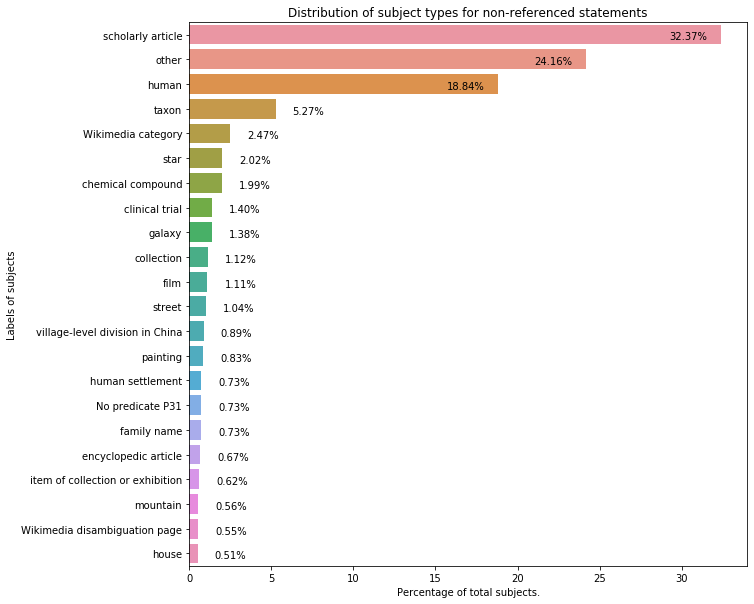

In [126]:
claims_no_refs_instance_of_count_other = aggregate_other(claims_no_refs_instance_of_count, by='label', other_thr=0.5)

fig, ax = plt.subplots(figsize=[10,10])

ax = sns.barplot(
    y = claims_no_refs_instance_of_count_other['label'],
    x = claims_no_refs_instance_of_count_other['per']
)

ax.set_title("Distribution of subject types for non-referenced statements")
ax.set(ylabel='Labels of subjects', xlabel='Percentage of total subjects.')

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 2 if width < 15 else width - 2 ,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}%'.format(width),
            ha="center")
    
plt.show()

### Analysis of properties and datatypes per top 'instance of' class

In [165]:
claims_no_refs_instance_of_count.head(21)

,instance_of,count,label
0,Q13442814,14342711,scholarly article
1,Q5,8346125,human
2,Q16521,2334634,taxon
3,Q4167836,1094166,Wikimedia category
4,Q523,894042,star
5,Q11173,882827,chemical compound
6,Q30612,621500,clinical trial
7,Q318,611557,galaxy
8,Q2668072,495569,collection
9,Q11424,492848,film


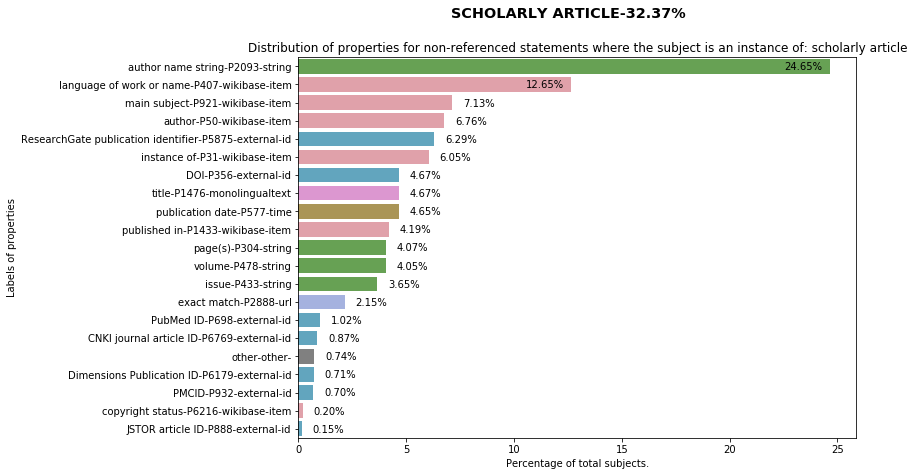

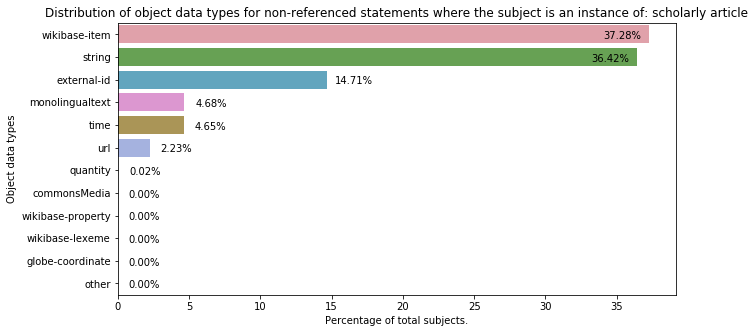

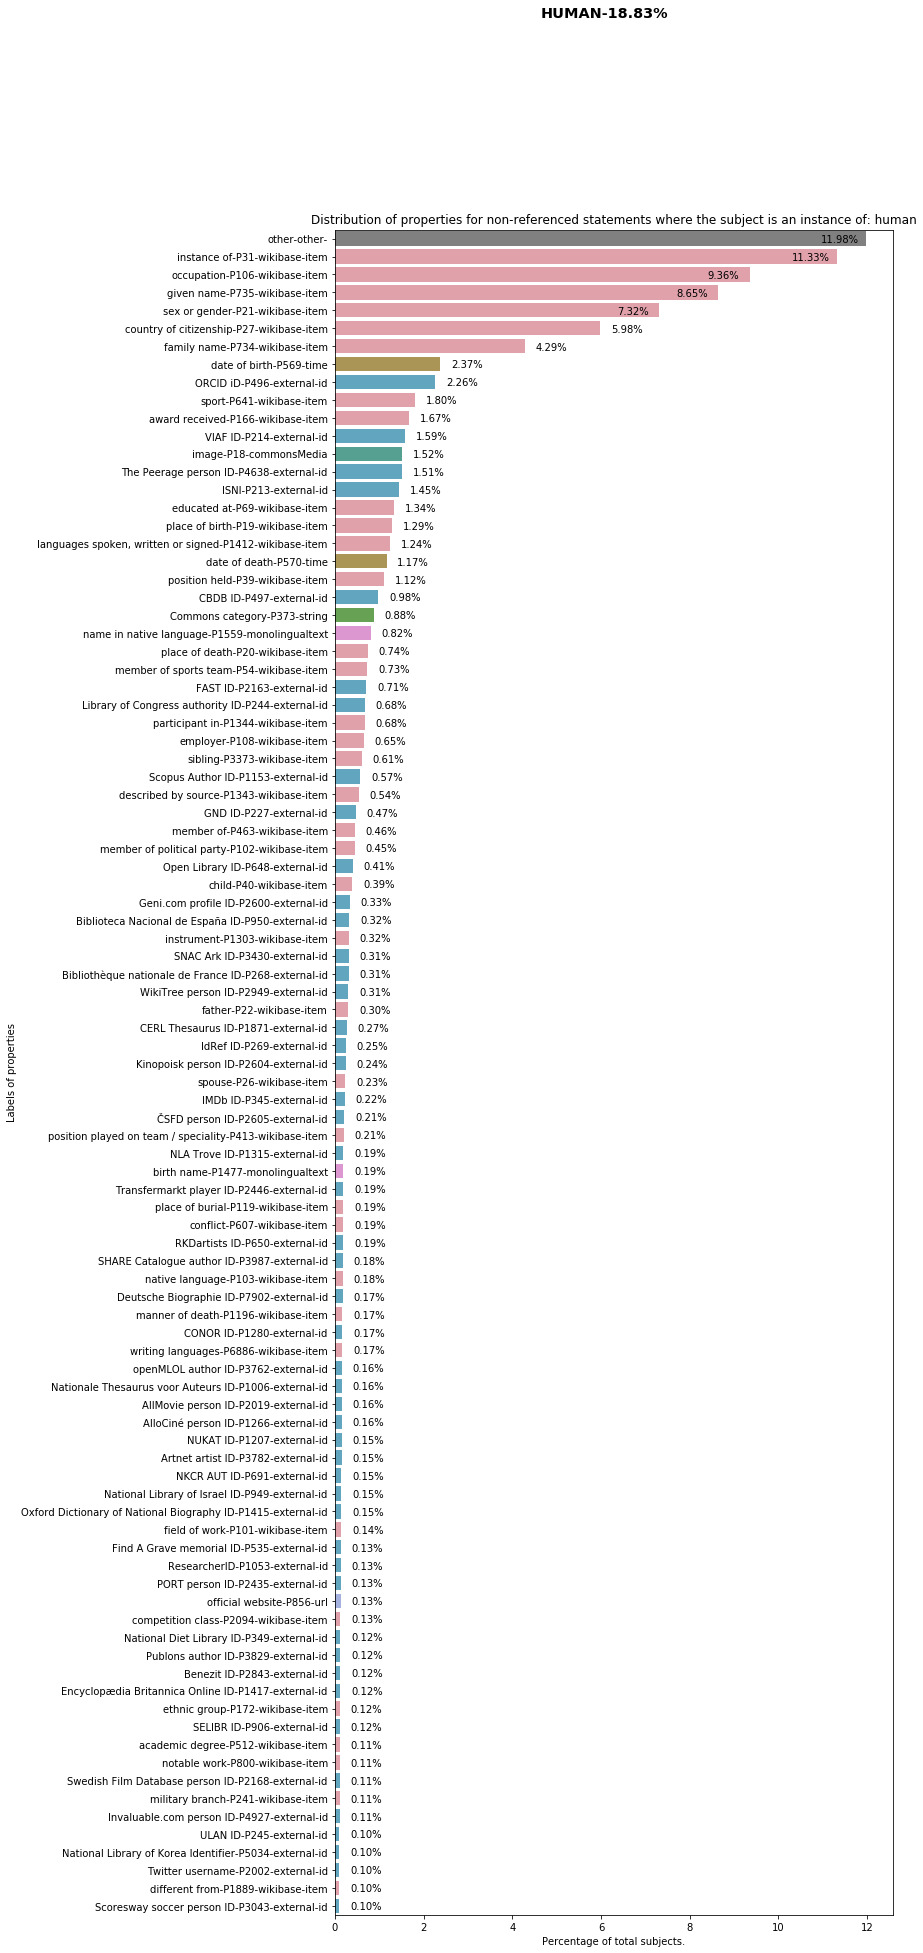

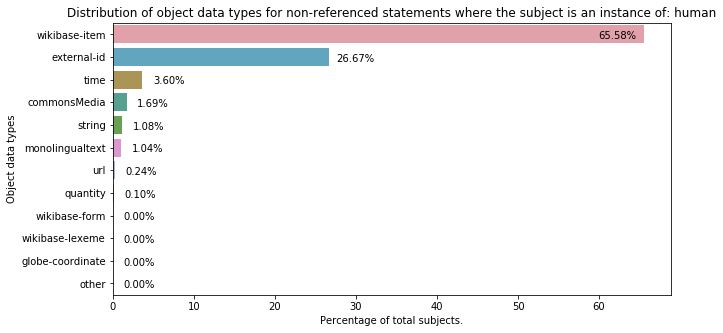

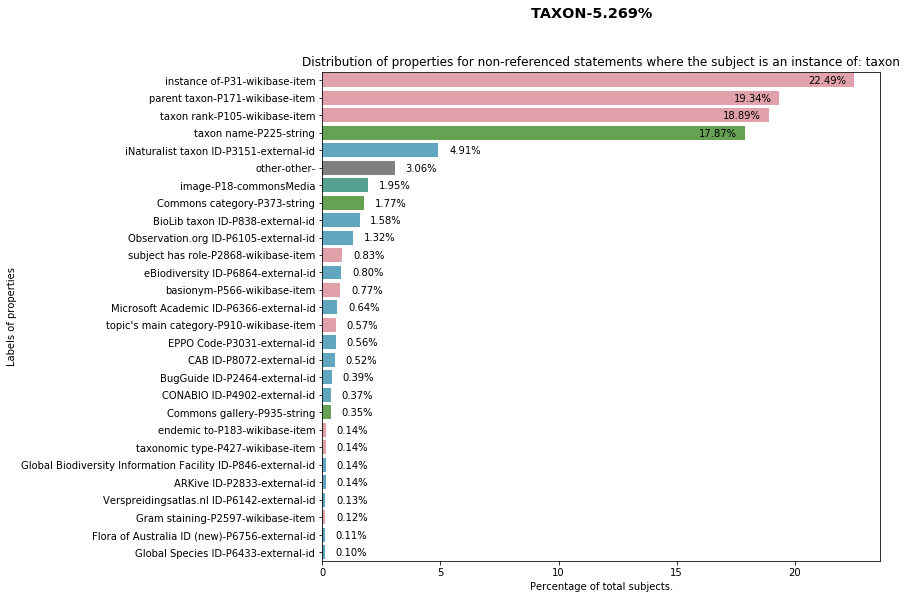

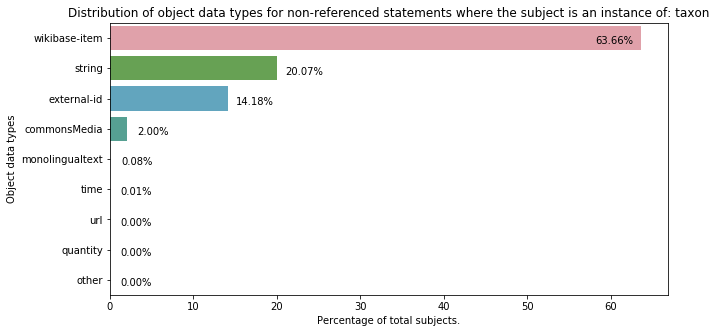

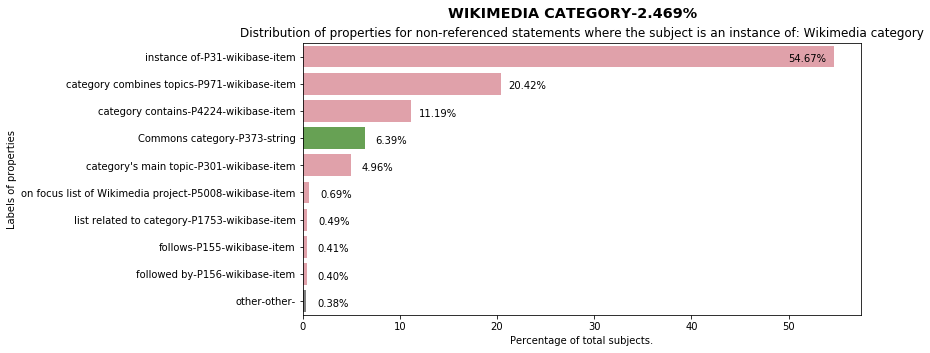

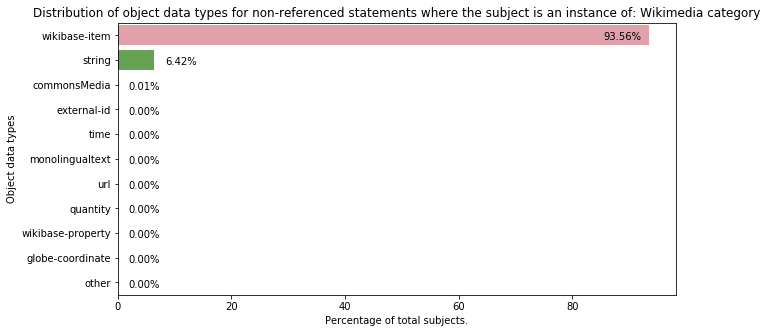

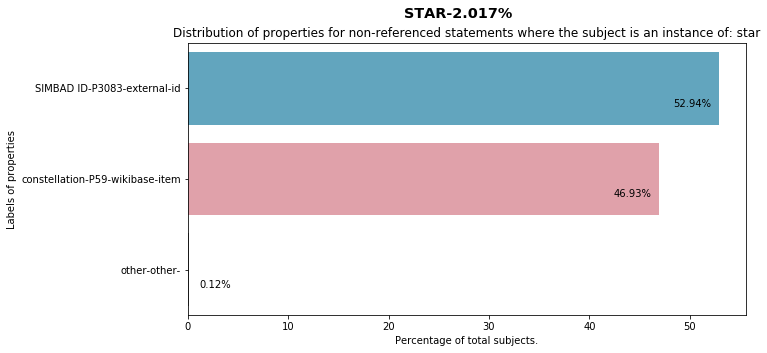

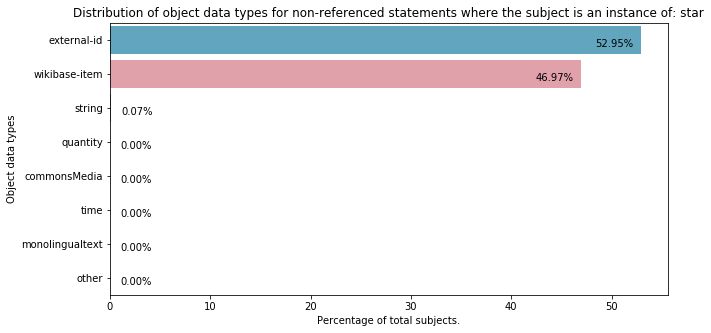

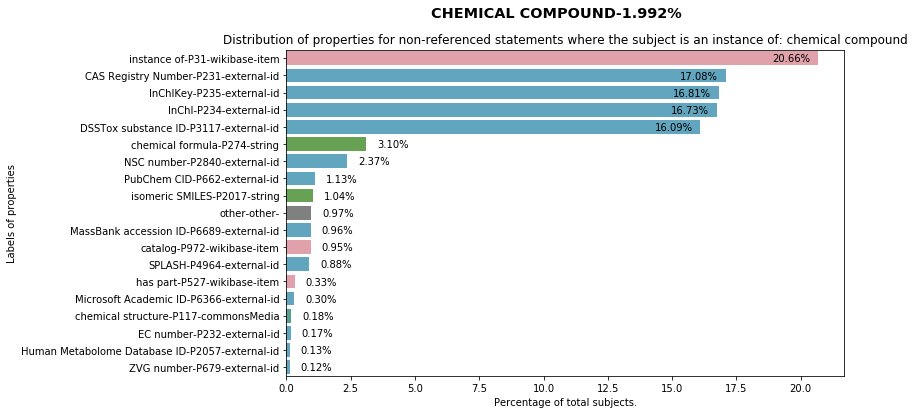

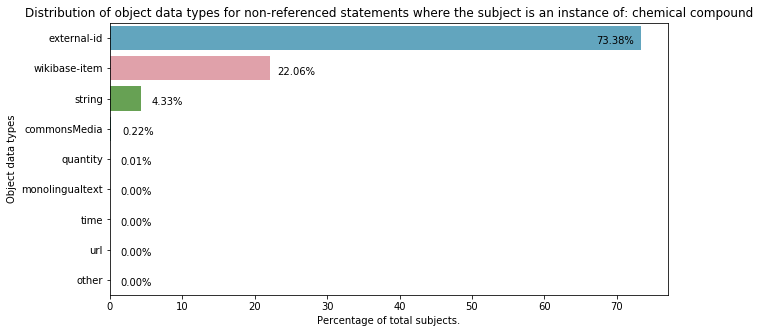

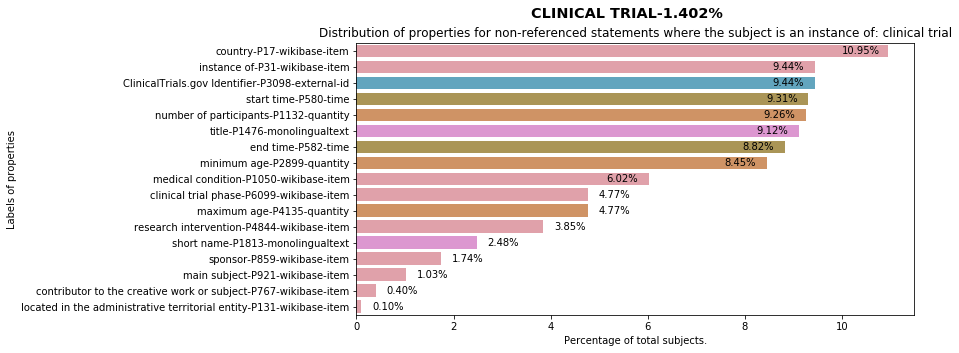

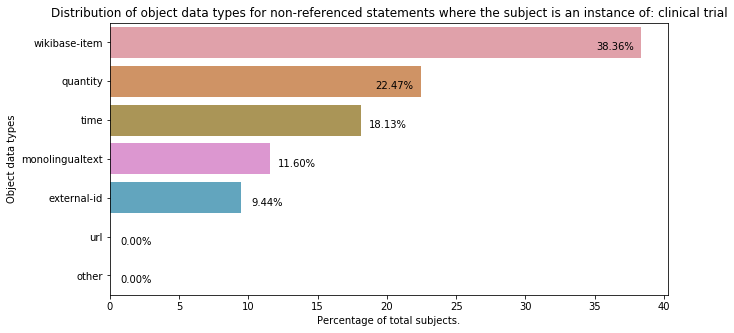

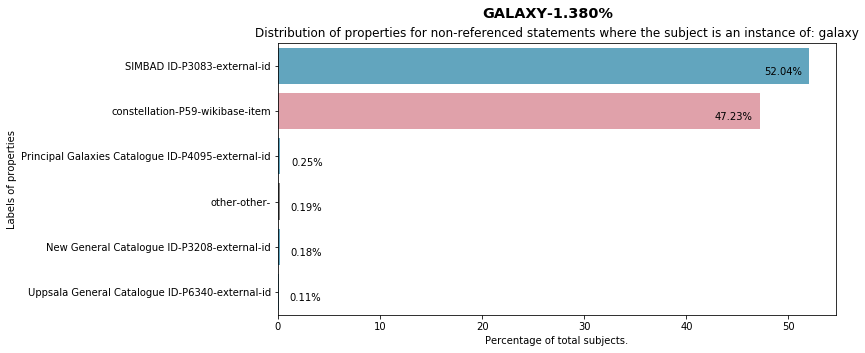

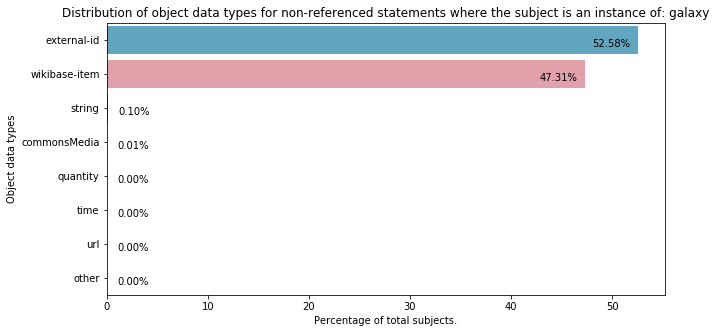

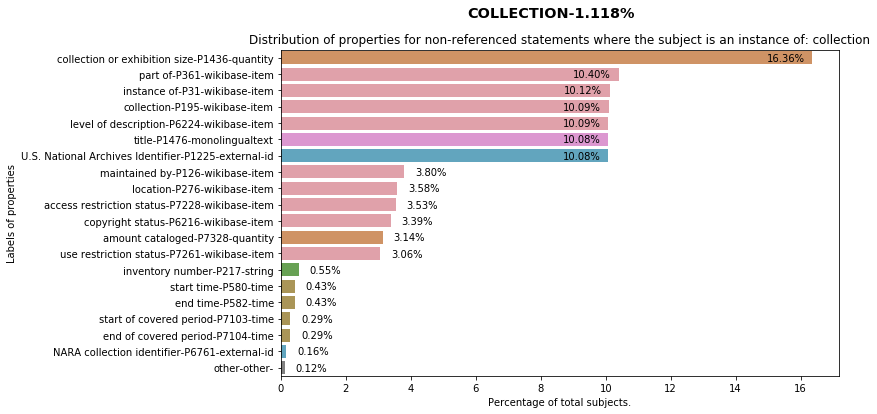

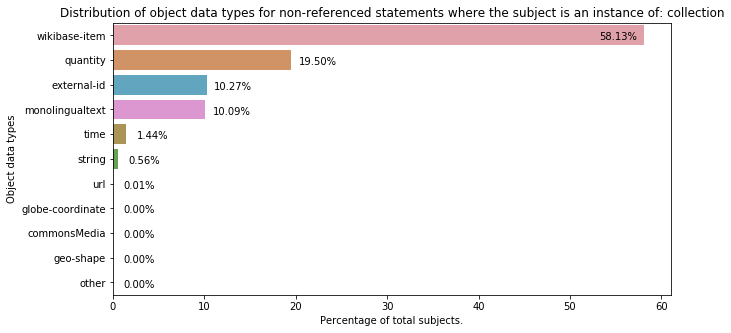

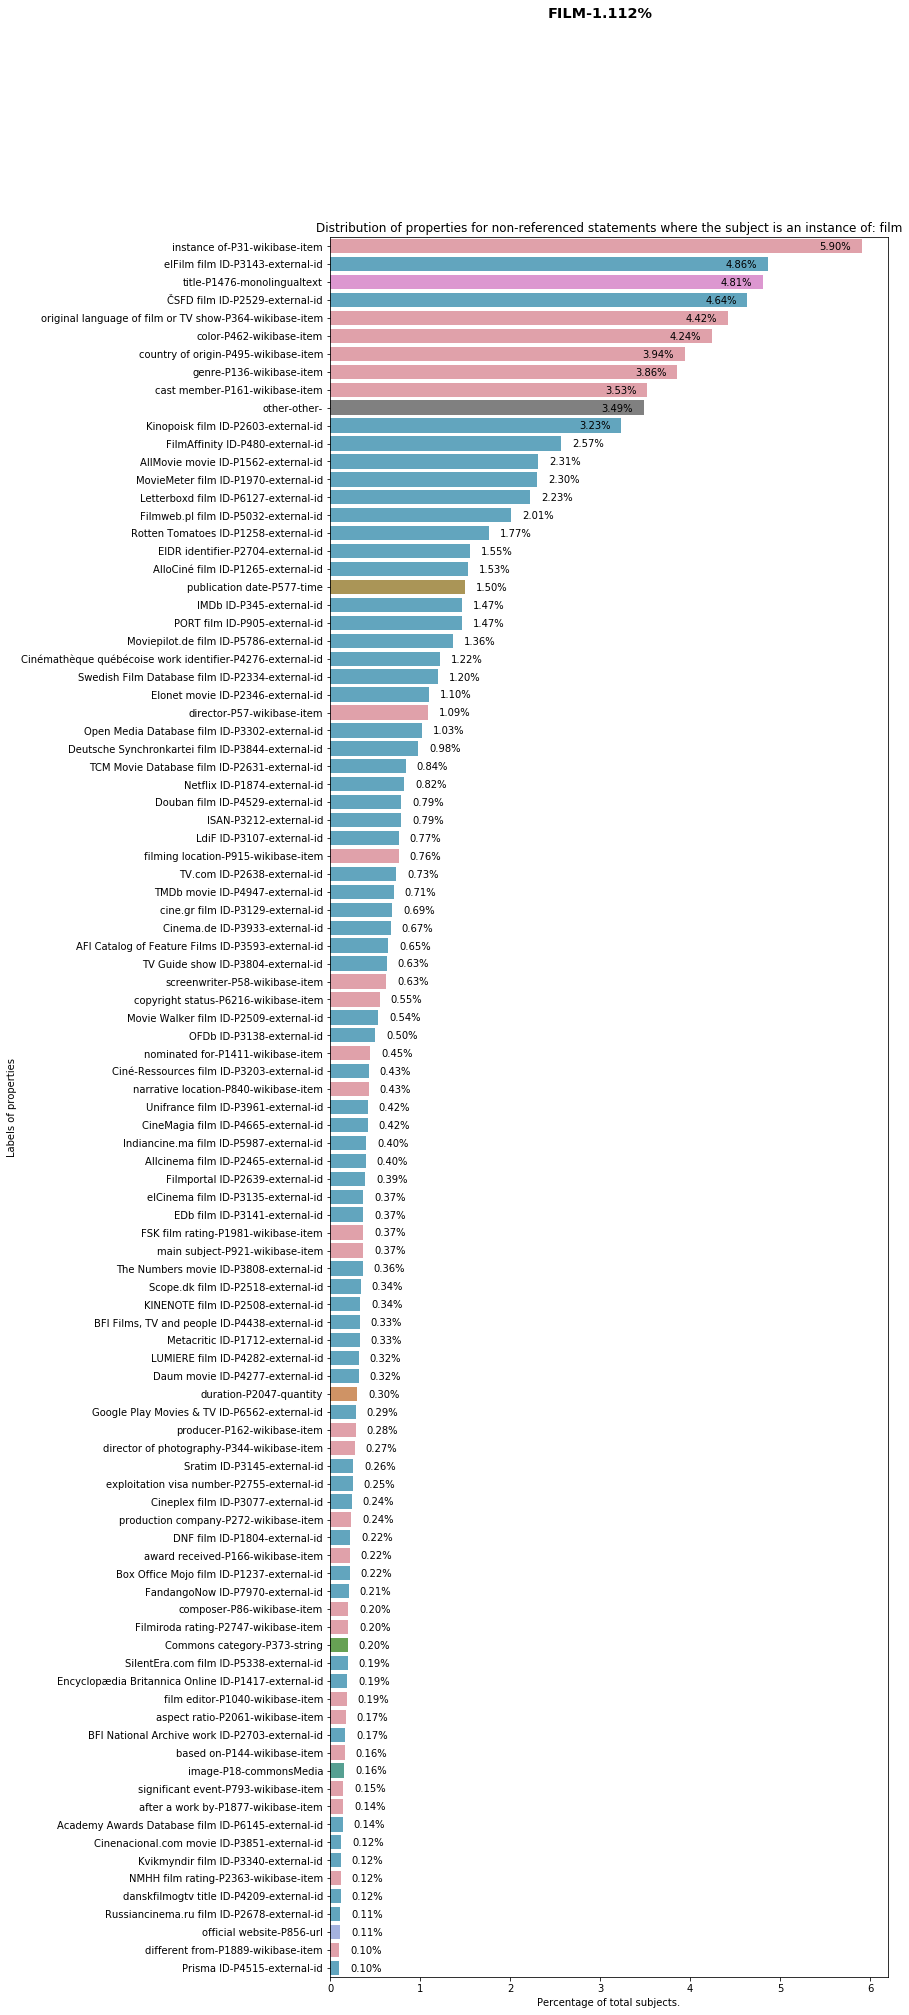

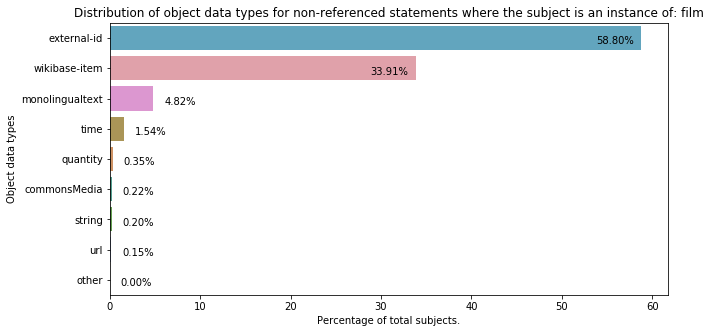

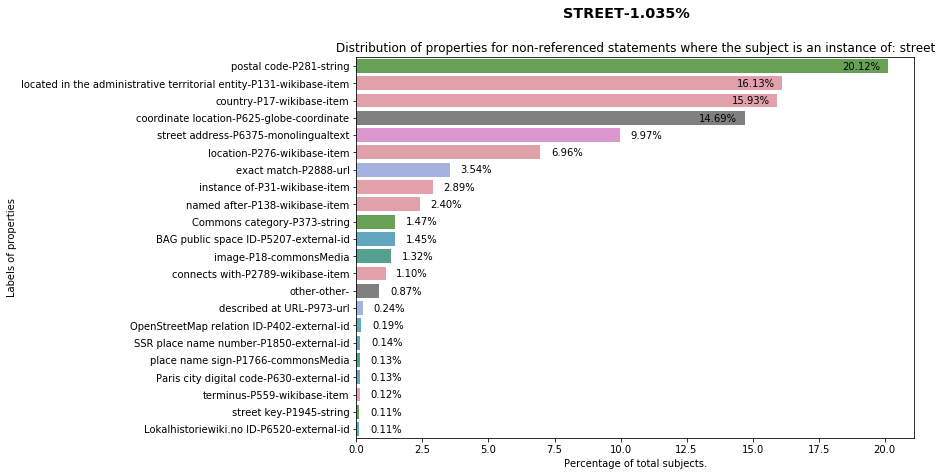

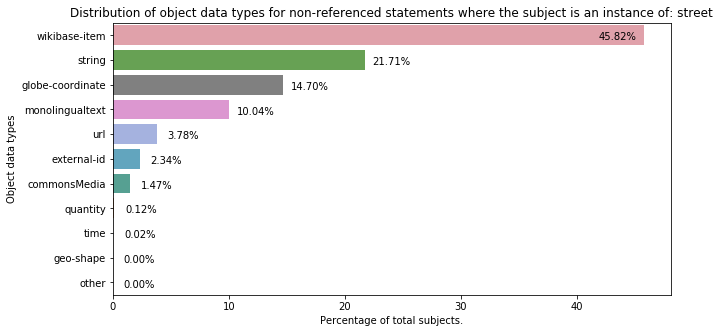

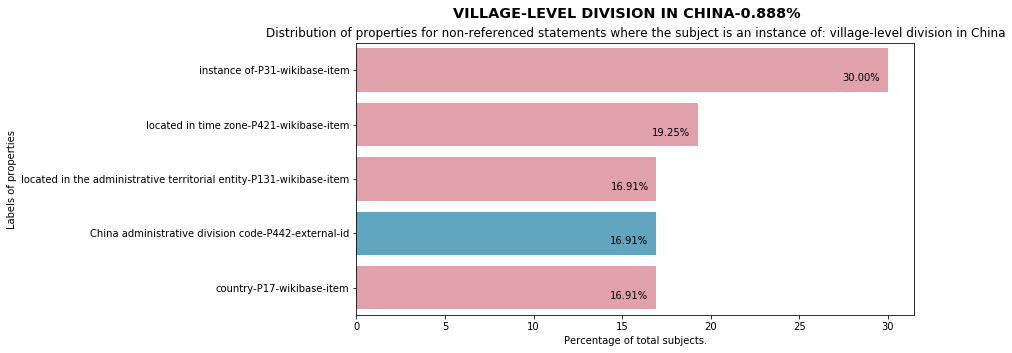

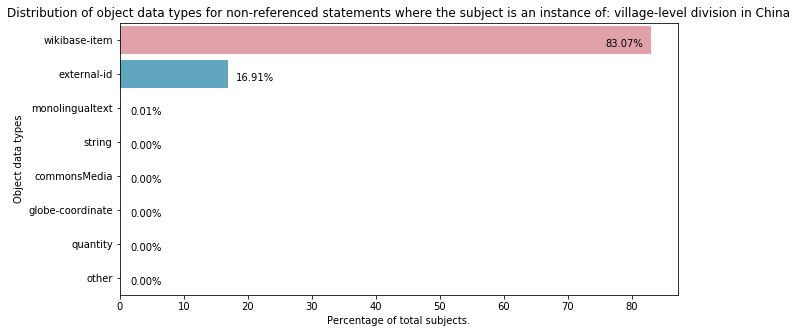

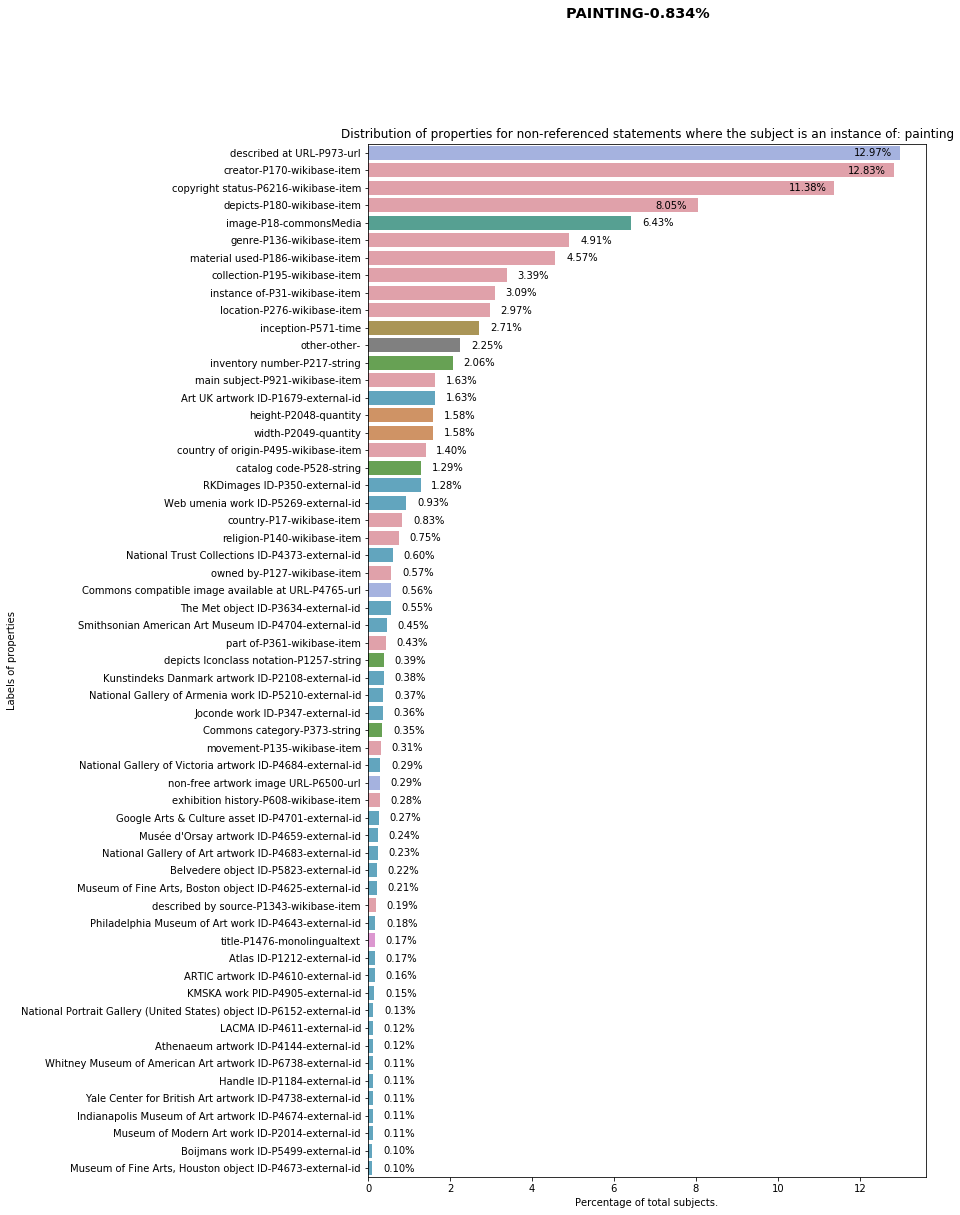

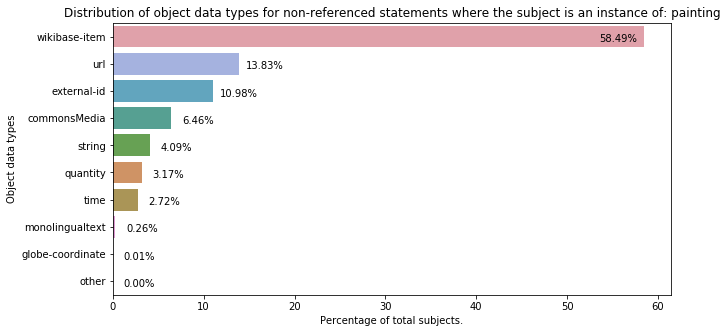

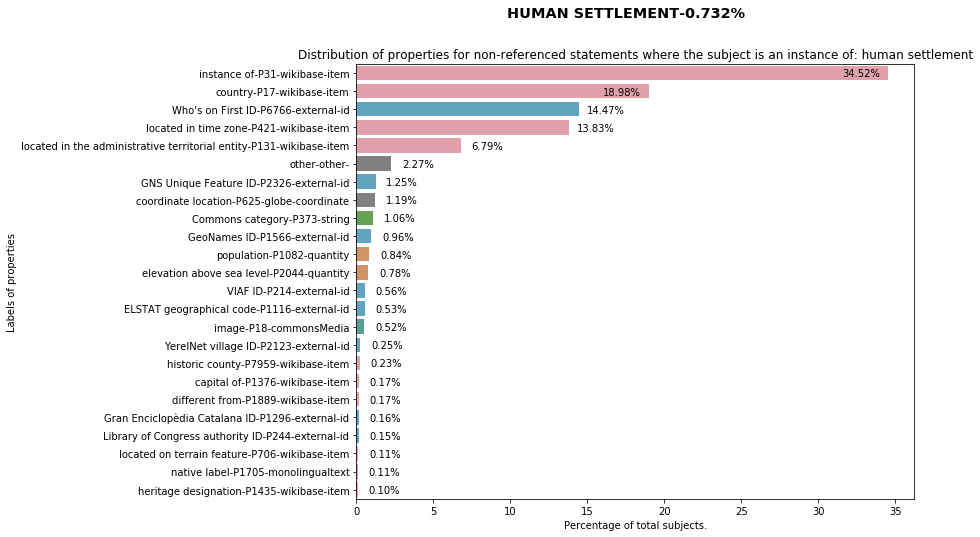

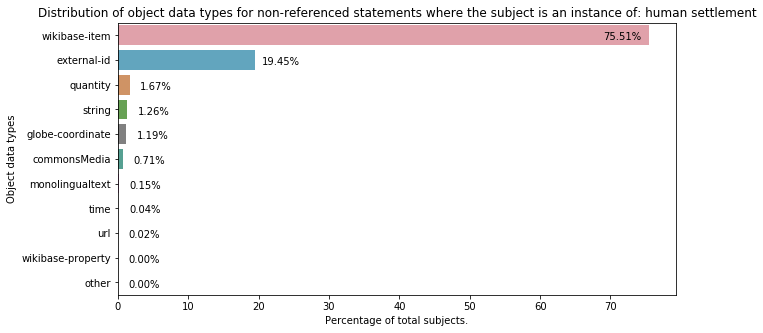

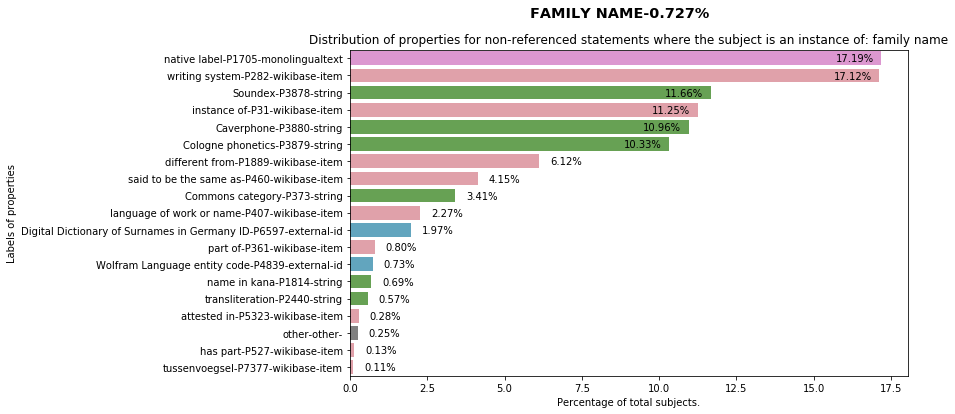

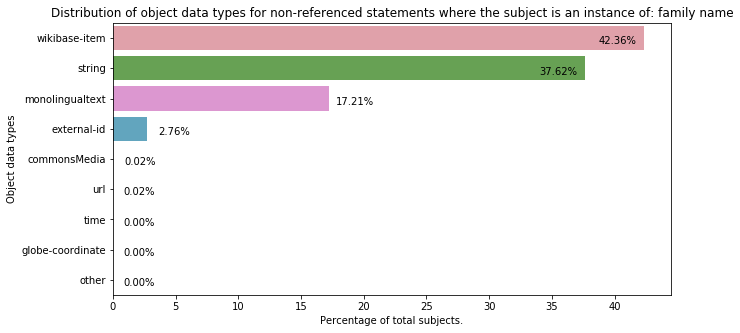

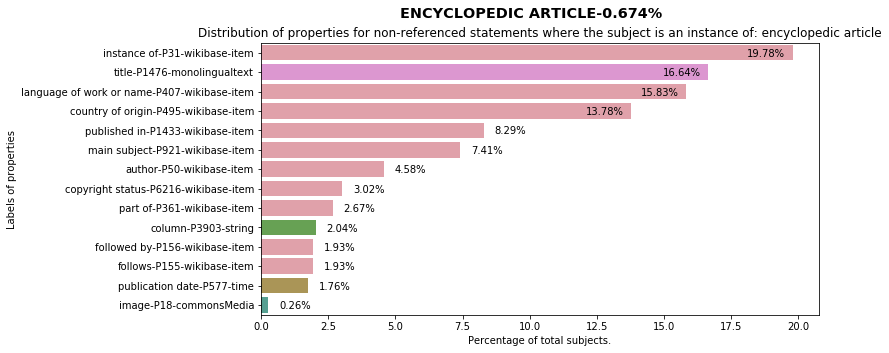

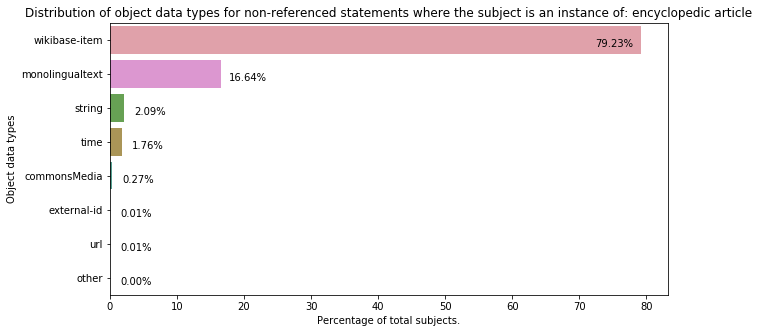

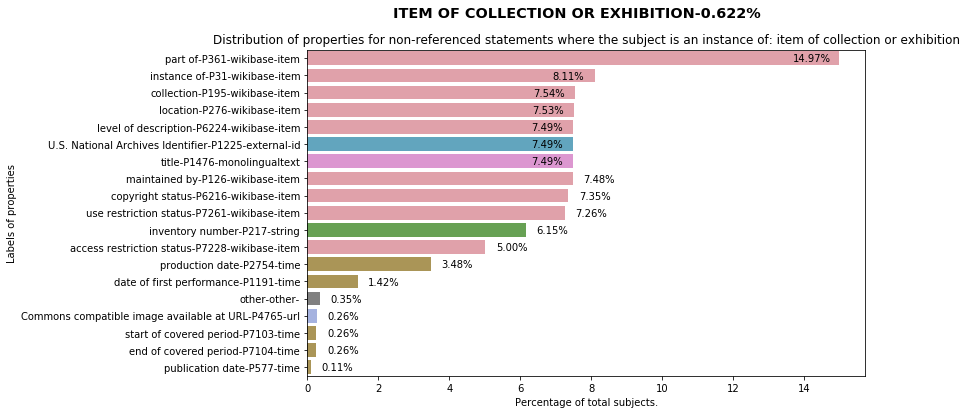

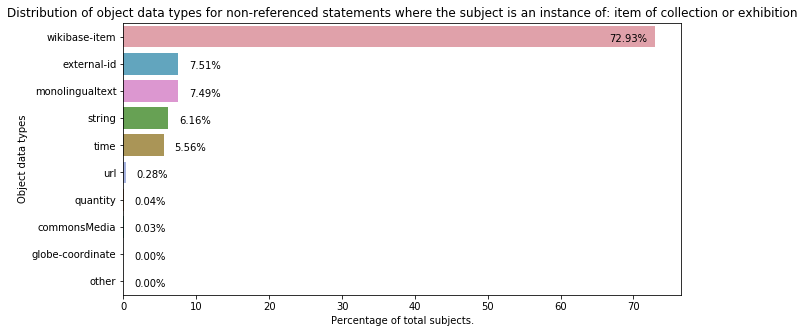

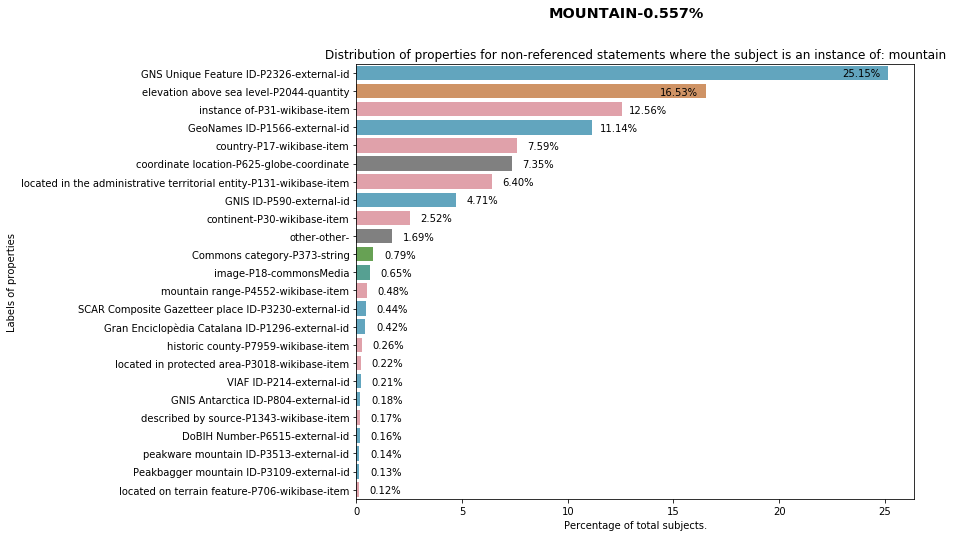

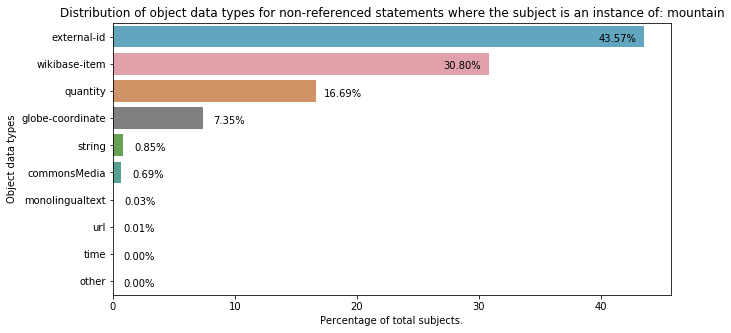

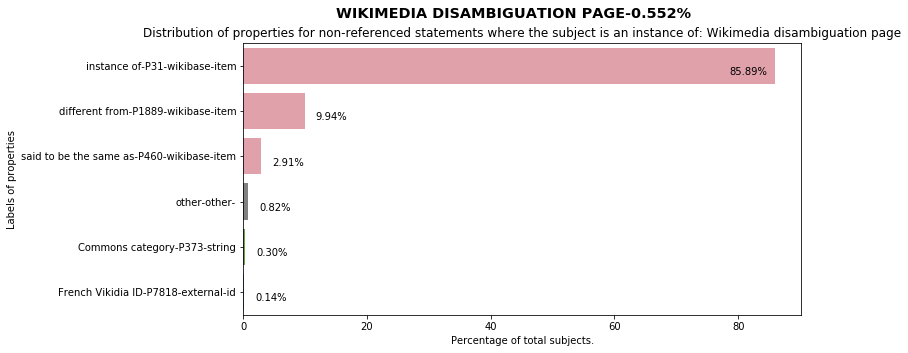

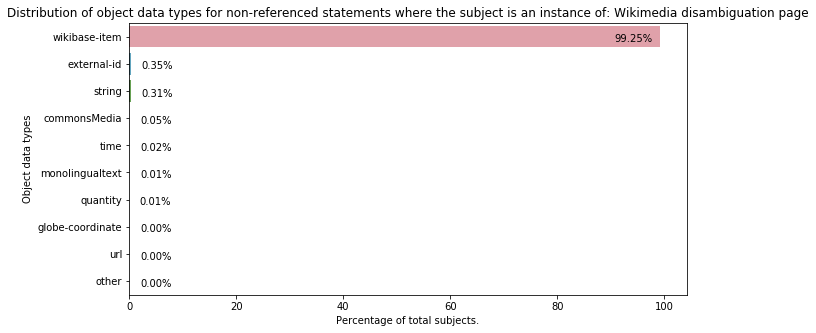

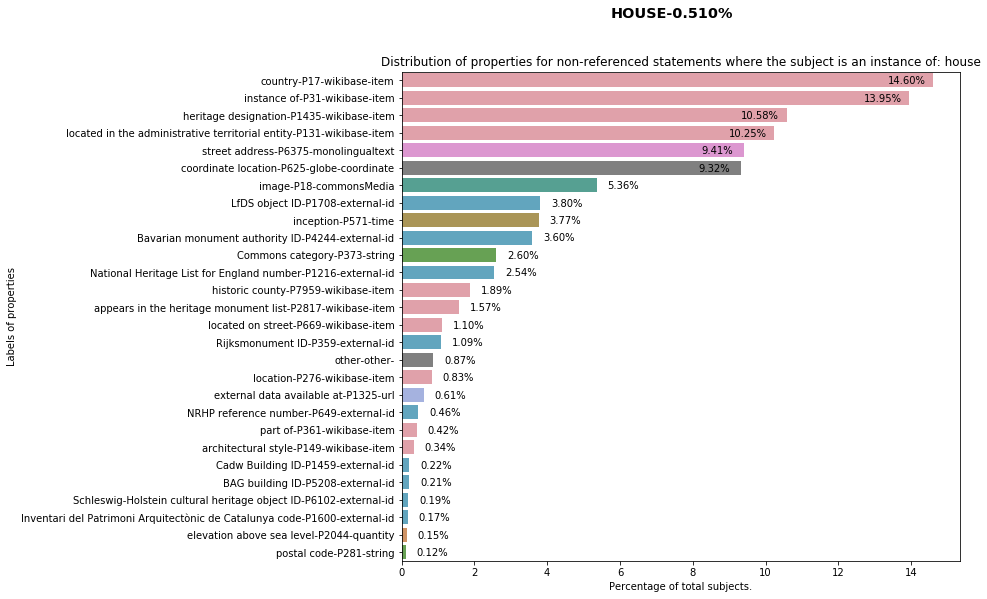

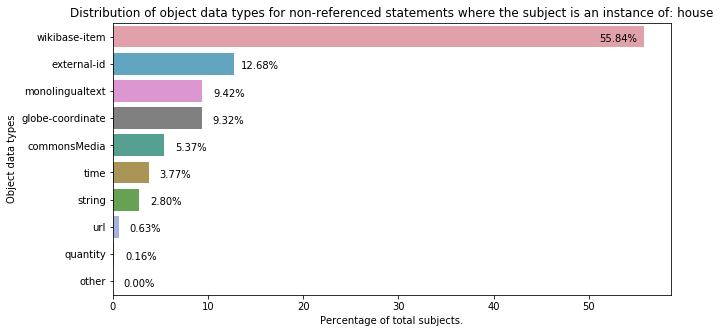

In [214]:
#instance_id = 'Q13442814'
for instance_id in claims_no_refs_instance_of_count.head(21)['instance_of']:
    if instance_id == 'No predicate P31':
        continue
    instance_of_df = claims_no_refs[claims_no_refs['instance_of'] == instance_id]
    
    instance_of_df_prop_count = instance_of_df['property_id'].value_counts().reset_index()
    instance_of_df_prop_count.columns = ['property_id','count']
    instance_of_df_prop_count = aggregate_other(instance_of_df_prop_count, by='property_id', other_thr=0.1)
    instance_of_df_prop_count['label'] = instance_of_df_prop_count['property_id'].apply(lambda x : get_label(x) if x!='other' else x)
    #print(max(instance_of_df_count['per']))

    fig, ax = plt.subplots(figsize=[10,max(5,instance_of_df_prop_count.shape[0]//3)])
    fig.suptitle(
        get_label(instance_id).upper() + '-' + str(claims_no_refs_instance_of_count_other[claims_no_refs_instance_of_count_other['label'] == get_label(instance_id)]['per'].values[0])[:5] + '%',
        size='x-large',weight='bold'
    )

    g = sns.barplot(
        y = instance_of_df_prop_count.apply(
            lambda x : x['label'] + '-' + x['property_id'] + '-' + (get_datatype(x['property_id']) if x['label'] != 'other' else ''), axis=1
        ),
        x = instance_of_df_prop_count['per'],
        palette = instance_of_df_prop_count.apply(
            lambda x : datatype_to_colour(get_datatype(x['property_id'])) if x['property_id'] != 'other' else 'gray', axis=1
        ),
        ax=ax
    )

    g.set_title("Distribution of properties for non-referenced statements where the subject is an instance of: {}".format(get_label(instance_id)))
    g.set(ylabel='Labels of properties', xlabel='Percentage of total subjects.')

    pad = max(instance_of_df_prop_count['per'])/20
    for p in g.patches:
        width = p.get_width()
        g.text(width + pad if width < pad*10 else width - pad ,
                p.get_y()+p.get_height()/2. + 0.2,
                '{:1.2f}%'.format(width),
                ha="center")
        
    plt.show()
        
    instance_of_df_datatype_count = instance_of_df['datatype'].value_counts().reset_index()
    instance_of_df_datatype_count.columns = ['datatype','count']
    instance_of_df_datatype_count = aggregate_other(instance_of_df_datatype_count, by='datatype', other_thr=0.0)

    fig, ax = plt.subplots(figsize=[10,5])
    
    g = sns.barplot(
        y = instance_of_df_datatype_count['datatype'],
        x = instance_of_df_datatype_count['per'],
        palette  = instance_of_df_datatype_count['datatype'].apply(datatype_to_colour),
        ax=ax
    )

    g.set_title("Distribution of object data types for non-referenced statements where the subject is an instance of: {}".format(get_label(instance_id)))
    g.set(ylabel='Object data types', xlabel='Percentage of total subjects.')

    pad = max(instance_of_df_datatype_count['per'])/20
    for p in g.patches:
        width = p.get_width()
        g.text(width + pad if width < pad*10 else width - pad ,
                p.get_y()+p.get_height()/2. + 0.2,
                '{:1.2f}%'.format(width),
                ha="center")

    plt.show()

### Subclass of

In [17]:
if update:
    subclass_of = [None]*11166227
    for i, row in claims_no_refs_entity_count.iterrows():
        if subclass_of[i] is not None:
            continue
        else:
            sql_cursor.execute(
                ''' select * from claims where entity_id = '{}' and property_id = 'P279';
             '''.format(row['entity_id'])
            )
            results = sql_cursor.fetchall()
            try:
                if len(results) > 0:
                    subclass_of[i] = ast.literal_eval(results[0][5])['value']['id']
                    #claims_no_refs_entity_count.loc[i,'subclass_of'] = ast.literal_eval(results[0][5])['value']['id']
                else:
                    subclass_of[i] = 'No predicate P279'
                    #claims_no_refs_entity_count.loc[i,'subclass_of'] = 'No predicate P31'
            except ValueError:
                subclass_of[i] = results[0][5]
                #claims_no_refs_entity_count.loc[i,'subclass_of'] = results[0][5]
                continue
        if i % 100 == 0:
            print(str((i+1)/claims_no_refs_entity_count.shape[0]*100) + '%' + 10*' ', end='\r')
    claims_no_refs_entity_count['subclass_of'] = subclass_of
    claims_no_refs_entity_count.to_csv('data/claims_no_refs_entity_count.csv',index=False)
else:
    claims_no_refs_entity_count = pd.read_csv('data/claims_no_refs_entity_count.csv')
claims_no_refs_entity_count

,entity_id,count,instance_of,subclass_of
0,Q64022985,5271,Q13442814,No predicate P279
1,Q57735077,4541,Q13442814,No predicate P279
2,Q56501626,3184,Q13442814,No predicate P279
3,Q57016199,3134,Q13442814,No predicate P279
4,Q57016667,3068,Q13442814,No predicate P279
...,...,...,...,...
11166222,Q48452423,1,Q13442814,No predicate P279
11166223,Q67635981,1,Q204107,No predicate P279
11166224,Q46483529,1,Q11266439,No predicate P279
11166225,Q72397092,1,Q13442814,No predicate P279


In [18]:
aggregate_other(
    claims_no_refs_entity_count.groupby('subclass_of').sum().sort_values('count', ascending=False).reset_index(),
    by = 'subclass_of',
    other_thr = 0.05
)

,subclass_of,count,per
0,No predicate P279,43848502,98.963165
1,other,377321,0.851589
2,Q15113603,29541,0.066672
3,Q382617,29255,0.066027
4,Q20747295,23283,0.052548


## Claim_rank

In [19]:
claims_no_refs_ranks_count = claims_no_refs['claim_rank'].value_counts().reset_index()
claims_no_refs_ranks_count.columns = ['claim_rank', 'count']
aggregate_other(claims_no_refs_ranks_count, by='claim_rank', other_thr=0.01)

,claim_rank,count,per
0,normal,44277581.0,99.931568
1,preferred,22027.0,0.049713
2,deprecated,8294.0,0.018719


## Property_id

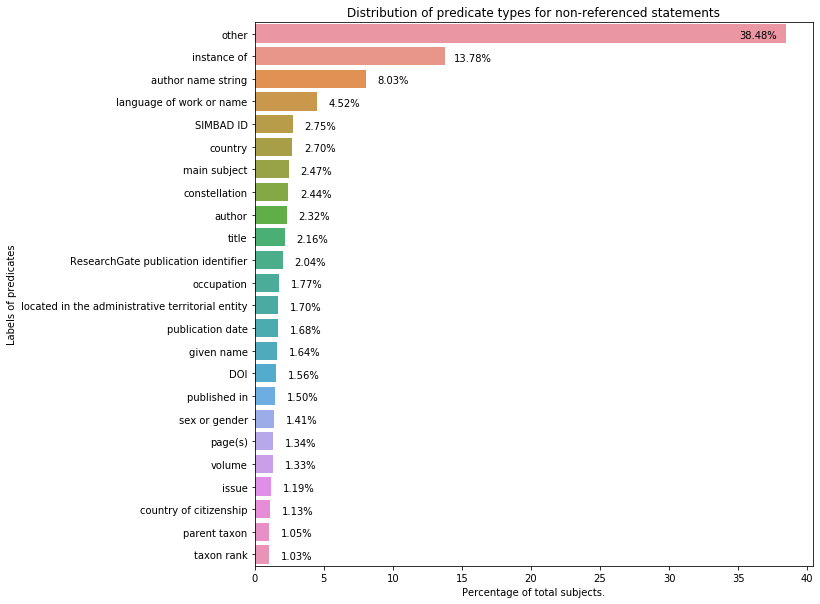

In [52]:
#claims_no_refs_property_id_counts = claims_no_refs['property_id'].value_counts().reset_index()
#claims_no_refs_property_id_counts.columns = ['property_id','count']
if update:
    claims_no_refs_property_id_counts = claims_no_refs['property_id'].value_counts().reset_index()
    claims_no_refs_property_id_counts.columns = ['property_id','count']
    claims_no_refs_property_id_counts_other = aggregate_other(claims_no_refs_property_id_counts, by='property_id')
    
    claims_no_refs_property_id_counts_other['label'] = None
    for i in range(claims_no_refs_property_id_counts_other.shape[0]):
        if claims_no_refs_property_id_counts_other.loc[i,'label'] != None:
            continue
        else:
            if not claims_no_refs_property_id_counts_other.loc[i,'property_id'].startswith('P'):
                claims_no_refs_property_id_counts_other.loc[i,'label'] = claims_no_refs_property_id_counts_other.loc[i,'property_id']
            else:
                claims_no_refs_property_id_counts_other.loc[i,'label'] = get_label(claims_no_refs_property_id_counts_other.loc[i,'property_id'])
    claims_no_refs_property_id_counts_other.to_csv('claims_no_refs_property_id_counts_other.csv', index=False)
else:
    claims_no_refs_property_id_counts_other = pd.read_csv('claims_no_refs_property_id_counts_other.csv')
claims_no_refs_property_id_counts_other

fig, ax = plt.subplots(figsize=[10,10])

ax = sns.barplot(
    y = claims_no_refs_property_id_counts_other['label'],
    x = claims_no_refs_property_id_counts_other['per']
)

ax.set_title("Distribution of predicate types for non-referenced statements")
ax.set(ylabel='Labels of predicates', xlabel='Percentage of total predicate usages.')

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 2 if width < 15 else width - 2 ,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}%'.format(width),
            ha="center")
    
plt.show()

## Datatype

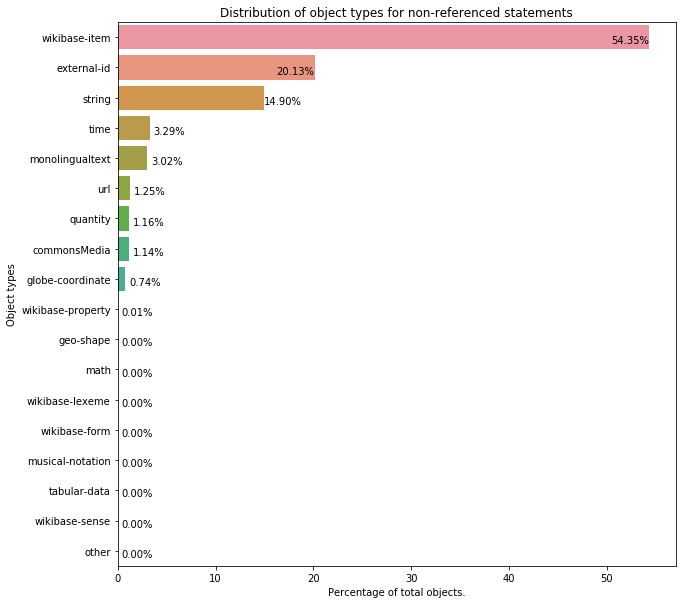

In [57]:
#claims_no_refs_datatype_counts = claims_no_refs['datatype'].value_counts().reset_index()
#claims_no_refs_datatype_counts.columns = ['datatype','count']
if True:
    claims_no_refs_datatype_counts = claims_no_refs['datatype'].value_counts().reset_index()
    claims_no_refs_datatype_counts.columns = ['datatype','count']
    claims_no_refs_datatype_counts = aggregate_other(claims_no_refs_datatype_counts, by='datatype',other_thr=0)
    
    claims_no_refs_datatype_counts.to_csv('claims_no_refs_datatype_counts.csv', index=False)
else:
    claims_no_refs_datatype_counts = pd.read_csv('claims_no_refs_datatype_counts.csv')


fig, ax = plt.subplots(figsize=[10,10])

ax = sns.barplot(
    y = claims_no_refs_datatype_counts['datatype'],
    x = claims_no_refs_datatype_counts['per']
)

ax.set_title("Distribution of object types for non-referenced statements")
ax.set(ylabel='Object types', xlabel='Percentage of total objects.')

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 2 if width < 15 else width - 2 ,
            p.get_y()+p.get_height()/2. + 0.2,
            '{:1.2f}%'.format(width),
            ha="center")
    
plt.show()

# Presentation and Conclusion

A presentation of the results can be found [here](https://docs.google.com/presentation/d/1SSyKBfquXjgfWMJjmnlf7A7k7RnQG3B79Hw6r-MrLKY/edit#slide=id.p)

Conclusion of this analysis:
- It is hard to pin any of these properties as being common knowledge just by looking at subject and property types, even the instance-of, which might follow a case-by-case basis
- There are too many subject-property combinations to analyse manually
- Some combinations are a case-by-case:
    - Earth orbits the Sun
    - TrES-3b orbits GSC 03089-00929
- Some rely mostly on the subject type
    - Scholarly articles, paintings, filmes tend not to need references
    - Humans, taxons, clinical trials, tend to need them
- A large portion of statements do not fit categories 2 and 3, and judging on category 1 is definitely not a trivial matter

Next steps to this would involve:
- Organising statements into subject-type / predicate / object-type triples
- Filtering out statements whose predicates have a internal-id datatype (statement has external ID)
- Compile a list of predicates which are likely to have the subject be its own source (e.g. author string, title, duration, etc)
- Parse remaining triples through some other knowledge base to verify how many of them are likely to be common knowledge.
- Perhaps use some technique to find possible references to the triples on the web (answering RQ3 first would clear this up a bit more)
